The final notebook in the series focused on analyzing the results of extracting impact sentences using BART large MNLI specifically by checking if the assumed threshold is qualified or not. Different ways to visualize the reuslts are shown below, notably are the confusion matrices and the F1 score.

Please ensure to paste the input_path, which is the location of the output of the 01_input.ipynb file, at the start of this notebook. This step is the only requirement to load all necessary information for the execution of the code.

Recommended Google Colab Runtime Type: CPU (default).

In [1]:
# Specify the directory path where the output of the input file 01_input.ipynb was saved
input_path = "/content/drive/My Drive/ImpactDataMining/Hurricane_Ian/01_Input"

All the below sections automatically retrieve data from the 01_input.ipynb file, as well as results from previous notebooks in this series. The code is designed to run using this information, so no further edits are required beyond this point.

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from google.colab import drive
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
import time

start_time = time.time()

In [4]:
def current_path():
  print("Current working directory")
  print(os.getcwd())
  print()

current_path()
drive.mount('/content/drive')
os.chdir(input_path)
current_path()

Current working directory
/content

Mounted at /content/drive
Current working directory
/content/drive/My Drive/ImpactDataMining/Hurricane_Ian/01_Input



In [5]:
with open('0_input.json', 'r') as file:
    data = json.load(file)
    output_path = data['output_path']
    keywords_non_impact = data['keywords_non_impact']
    threshold = data['threshold']

with open('4_data_labeling.json', 'r') as file:
    data = json.load(file)
    s_struct = data['labeled_data_struct']
    s_comm = data['labeled_data_comm']
    s_both = data['labeled_data_both']

In [6]:
os.makedirs(output_path, exist_ok=True)
os.chdir(output_path)
current_path()

Current working directory
/content/drive/My Drive/ImpactDataMining/Hurricane_Ian/03_Output



In [7]:
with open('1_output.json', 'r') as file:
    data = json.load(file)
    idx_body = data['idx_body']
    idx_table = data['idx_table']

with open('2a_output.json', 'r') as file:
    data = json.load(file)
    sent_all = data['sent_all']
    keywords = data['labels']
    label_pred = data['result_probs']
    result_labels = data['result_labels']

In [8]:
data_struct = s_struct + s_both
data_comm = s_comm + s_both
data_impact = s_struct + s_comm + s_both

In [9]:
for i, n in enumerate(result_labels):
  if n in keywords_non_impact:
    label_pred[i] = 0

In [10]:
y_true = [1 if n in data_impact else 0 for n in sent_all]
y_pred_6 = [1 if n >= .6 else 0 for n in label_pred]
y_pred_7 = [1 if n >= .7 else 0 for n in label_pred]
y_pred_8 = [1 if n >= .8 else 0 for n in label_pred]
y_pred_9 = [1 if n >= .9 else 0 for n in label_pred]

In [11]:
def confusion_matrix_para(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    confusion_mat = confusion_matrix(y_true, y_pred)

    return acc, pre, rec, f1, confusion_mat

In [12]:
acc_6, pre_6, rec_6, f1_6, confusion_mat_6 = confusion_matrix_para(y_true, y_pred_6)
acc_7, pre_7, rec_7, f1_7, confusion_mat_7 = confusion_matrix_para(y_true, y_pred_7)
acc_8, pre_8, rec_8, f1_8, confusion_mat_8 = confusion_matrix_para(y_true, y_pred_8)
acc_9, pre_9, rec_9, f1_9, confusion_mat_9 = confusion_matrix_para(y_true, y_pred_9)

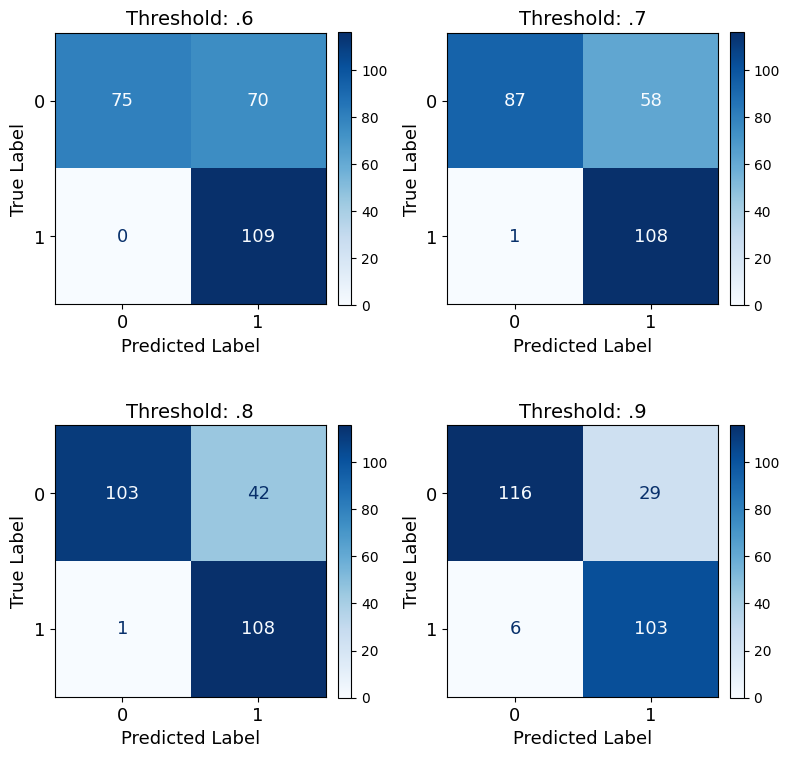

In [13]:
# Stack the confusion matrices
confusion_mat = np.stack((confusion_mat_6, confusion_mat_7, confusion_mat_8, confusion_mat_9))
vmin = np.min(confusion_mat)
vmax = np.max(confusion_mat)
titles = ['Threshold: .6', 'Threshold: .7', 'Threshold: .8', 'Threshold: .9']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # Adjust the overall figure size as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes into a 1D array for easier iteration

for ax, matrix, title in zip(axes, confusion_mat, titles):
    # Plot each confusion matrix in its respective subplot
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['0', '1'])
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d', colorbar=False)

    ax.set_xlabel('Predicted Label', fontsize=13)
    ax.set_ylabel('True Label', fontsize=13)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_title(title, fontsize=14)

    # Increase font size of x-tick and y-tick labels
    ax.tick_params(axis='both', which='major', labelsize=13)

    # Increase font size of numbers inside the confusion matrix
    for text in ax.texts:
        text.set_size(13)

    # Optionally add colorbar to each subplot if needed
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(cmap=plt.cm.Blues, norm=norm)
    sm.set_array([])  # This line is needed to make 'sm' aware of the new norm
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


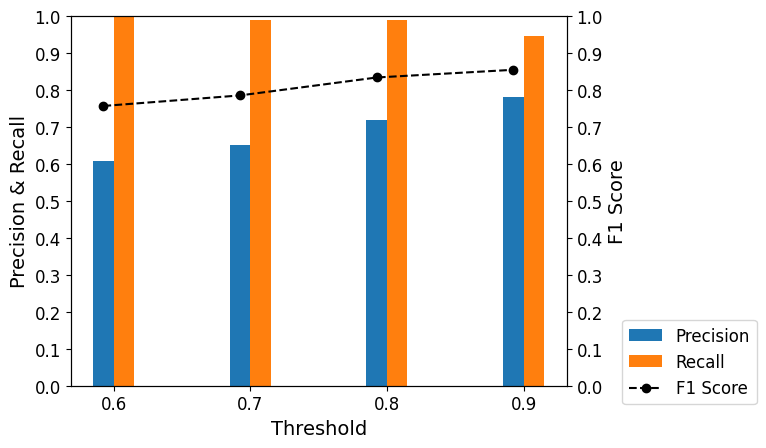

In [14]:
# Create data for each bar chart
acc = [acc_6, acc_7, acc_8, acc_9]
pre = [pre_6, pre_7, pre_8, pre_9]
rec = [rec_6, rec_7, rec_8, rec_9]

F1 = [f1_6, f1_7, f1_8, f1_9]

# Set the positions of the bars on the x-axis
x = range(len(pre))

# Set the width of each bar
width = 0.15

# Create the figure and axis objects
fig, ax1 = plt.subplots()

# Plot the bar charts
ax1.bar(x, pre, width=width, label='Precision')
ax1.bar([val + width for val in x], rec, width=width, label='Recall')

# Adjust the x-tick positions to be at the center between the bars
tick_positions = [val + width/2 for val in x]

# Set the x-axis tick positions and labels
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(['0.6', '0.7', '0.8', '0.9'], fontsize=12)

# Create a second y-axis
ax2 = ax1.twinx()

# Line chart related to the right y-axis
ax2.plot(x, F1, color='k', marker='o', linestyle='--', label='F1 Score')

# Set the y-axis limits
ax1.set_ylim([0, 1])
ax1.set_yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks for ax1
ax1.tick_params(axis='y', labelsize=12)  # Adjust y-tick font size for ax1

ax2.set_ylim([0, 1])
ax2.set_yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks for ax2
ax2.tick_params(axis='y', labelsize=12)  # Adjust y-tick font size for ax2

# Set the title and labels
ax1.set_xlabel('Threshold', fontsize=14)
ax1.set_ylabel('Precision & Recall', fontsize=14)
ax2.set_ylabel('F1 Score', fontsize=14)

# Get the handles and labels from ax1 and ax2
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles += handles2
labels += labels2

# Create a single legend for both ax1 and ax2
plt.legend(handles, labels, bbox_to_anchor=(1.4, 0.2), fontsize=12)

# Show the plot
plt.show()

In [15]:
table = {'Threshold': ['0.6', '0.7', '0.8', '0.9-'],
         'Accuracy': acc,
         'Precision': pre,
         'Recall': rec,
         'F1 Score': F1}
df = pd.DataFrame(table)
df

,Threshold,Accuracy,Precision,Recall,F1 Score
0,0.6,0.724409,0.608939,1.000000,0.756944
1,0.7,0.767717,0.650602,0.990826,0.785455
2,0.8,0.830709,0.720000,0.990826,0.833977
3,0.9-,0.862205,0.780303,0.944954,0.854772


In [16]:
y_pred = [1 if n >= threshold else 0 for n in label_pred]

true_positives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 1 and y == 1]
true_negatives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 0 and y == 0]
false_negatives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 1 and y == 0]
false_positives = [i for i, (x, y) in enumerate(zip(y_true, y_pred_9)) if x == 0 and y == 1]

In [17]:
def display_results(data, idx, result_labels, prob):
  sentences = [data[i] for i in idx]
  labels = [result_labels[i] for i in idx]
  probability = [prob[i] for i in idx]
  data = {'Sentences': sentences, 'Labels': labels, 'Probability': probability}
  df = pd.DataFrame(data)
  return df

In [18]:
print('Sentences with False Positive label')
df_false_positive = display_results(sent_all, false_positives, result_labels, label_pred)
df_false_positive

Sentences with False Positive label


,Sentences,Labels,Probability
0,"Unlike Hurricane Charley (2004), water more so...",secondary water resistance damage,0.973385
1,It is notable that extensive losses were in pa...,building damage,0.967927
2,Interested readers may also consult the accomp...,service loss,0.977953
3,The death toll included 119 storm-related fata...,fatalities,0.992617
4,The majority of the deaths (57) were reported ...,fatalities,0.991090
5,"For a preliminary comparison, Hurricane Irma (...",fatalities,0.980405
6,Hurricane Michael (2018) caused 8 direct death...,fatalities,0.987524
7,Hurricane Andrew (1992) caused 15 direct death...,fatalities,0.987381
8,It should be noted that 2 injuries and damage ...,school damage,0.939973
9,All major structures are required to be design...,infrastructure resilience,0.925303


In [19]:
print('Sentences with False Negative label')
df_false_negative = display_results(sent_all, false_negatives, result_labels, label_pred)
df_false_negative

Sentences with False Negative label


,Sentences,Labels,Probability
0,"In contrast, wind damage from Hurricane Ian ap...",infrastructure resilience,0.835540
1,The historical context of these numbers remain...,fatalities,0.837577
2,"Beyond Babcock Ranch, however, aerial imagery ...",roof damage,0.886894
3,Two other types of damage were also observed i...,causeway damage,0.875137
4,"The surge and flood impacts were more severe, ...",secondary water resistance damage,0.620285
5,Several critical facilities experienced signif...,infrastructure resilience,0.829245


In [20]:
df.to_excel('5_F1score.xlsx', index=False)

In [21]:
end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 33.55747389793396 seconds
